In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dog_epidemic.Utils as utils
from datetime import date
import numpy as np
import shapely
from shapely import Point
from shapely import Polygon
import random
import geopandas as gp

In [2]:
all_dogs = gp.read_parquet('ALLNYCDogs.parquet')

0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed
0 dogs exposed


ValueError: aspect must be finite and positive 

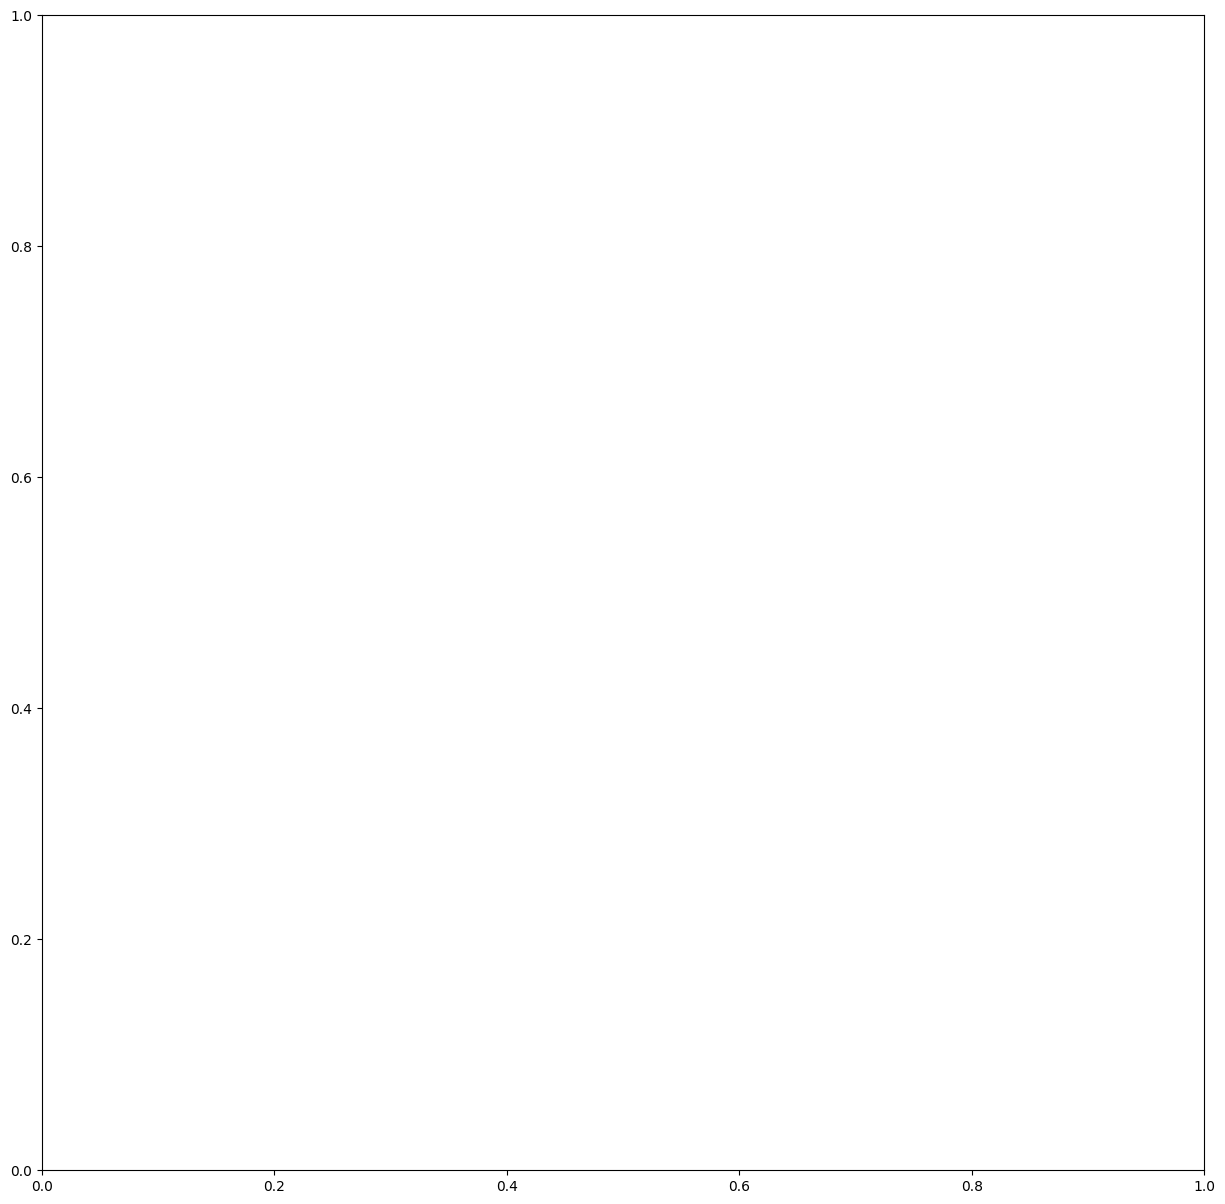

In [24]:
# set parameters
n_generation_intervals = 2
percent_infected = 0.005
i = 0
frame = 0
SEIR_report = pd.DataFrame({'Susceptible': [], 
                            'Exposed': [], 
                            'Infected': [], 
                            'Recovered': []})
R_report = pd.DataFrame()

# Set initial conditions

# Randomly infect the first generation of dogs
exposed_dogs = all_dogs.sample(10)

# Remove infected dogs from susceptible dogs 
susceptible_dogs = pd.merge(all_dogs.set_index('ID'), 
                             exposed_dogs['ID'], 
                             on = ['ID'], how = 'outer',
                             suffixes = ('', '_ex'),
                             indicator=True).query('_merge=="left_only"').drop('_merge', axis = 1)

recovered_dogs = pd.DataFrame()

infected_dogs = pd.DataFrame()

new_row = pd.DataFrame.from_records([{'Susceptible': len(susceptible_dogs), 
           'Exposed': len(exposed_dogs),
           'Infected': len(infected_dogs),
           'Recovered': len(recovered_dogs)}])
SEIR_report = pd.concat([SEIR_report, new_row], ignore_index=True)

# Run simulation for n generation intervals
while i < n_generation_intervals: 
    i = i + 1
    # Move dogs to next compartment
    recovered_dogs = pd.concat([recovered_dogs, infected_dogs])
    infected_dogs = exposed_dogs
    exposed_dogs = pd.DataFrame()

    # Show infected dogs at start of step
    fig, ax = plt.subplots(figsize=(15, 15))
    figname = 'Figures/' + str(frame) + '.png'
    infected_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    if len(recovered_dogs) > 0 :
        recovered_dogs['geometry'].plot(ax = ax, color = 'lightgray')
        recovered_dogs['locations'].plot(ax = ax, color = 'lavender')
    infected_dogs['locations'].plot(ax = ax, color = 'red')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    frame = frame + 1

    # Create walks for infected dogs 
    infected_dogs['walk'] = infected_dogs.apply(utils.create_walk, axis =1, location = 'locations', distance = 0.005, buffer = 0.0005)

    # Show area of exposure
    fig, ax = plt.subplots(figsize=(15, 15))
    figname = 'Figures/' + str(frame) + '.png'
    infected_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    if len(recovered_dogs) > 0 :
        recovered_dogs['geometry'].plot(ax = ax, color = 'lightgray')
        recovered_dogs['locations'].plot(ax = ax, color = 'lavender')
    infected_dogs['walk'].plot(ax = ax, color = 'pink')
    infected_dogs['locations'].plot(ax = ax, color = 'red')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    frame = frame + 1

    # Find all dogs exposed during this step
    for index, row in infected_dogs.iterrows():
        new_exposures = utils.infect_dog_along_walk(row,
                            walk = 'walk',
                            infected_dogs=infected_dogs, 
                            recovered_dogs=recovered_dogs, 
                            susceptible_dogs=susceptible_dogs,
                            exposed_dogs= exposed_dogs,
                            location='locations', 
                            percent_infected=percent_infected)
        exposed_dogs= pd.concat([exposed_dogs,new_exposures])

    susceptible_dogs = pd.merge(susceptible_dogs.set_index('ID'), 
                             exposed_dogs['ID'], 
                             on = ['ID'], how = 'outer',
                             suffixes = ('', '_ex'),
                             indicator=True).query('_merge=="left_only"').drop('_merge', axis = 1)
    # Plot newly exposed dogs 
    fig, ax = plt.subplots(figsize=(15, 15))
    figname = 'Figures/' + str(frame) + '.png'
    exposed_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    infected_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    if len(recovered_dogs) > 0 :
        recovered_dogs['geometry'].plot(ax = ax, color = 'lightgray')
        recovered_dogs['locations'].plot(ax = ax, color = 'lavender')
    infected_dogs['walk'].plot(ax = ax, color = 'pink')
    infected_dogs['locations'].plot(ax = ax, color = 'red')
    exposed_dogs['locations'].plot(ax = ax, color = 'black')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    frame = frame + 1

    new_row = pd.DataFrame.from_records([{'Susceptible': len(susceptible_dogs), 
           'Exposed': len(exposed_dogs),
           'Infected': len(infected_dogs),
           'Recovered': len(recovered_dogs)}])
    SEIR_report = pd.concat([SEIR_report, new_row], ignore_index=True)